# Showing why PCA preprocessing in single-cell genomics is a bad idea

For the manuscript. For now only have 14 datasets, but the example sufficies.

In [1]:
import glob
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from pcaeval.pca_eval import (evaluate_anndata_file_list, plot_sing_vals_exp_var,
                              process, preprocess, evaluate_anndata, print_dict_results,
                              _plot_explained_variance, _plot_singular_values)

In [2]:
wd = '/home/davi/Bioinfo/PCA_distortion/'
data_dir = '/home/davi/Bioinfo/BenchmarkDatasets/data/'
save_dir = '/home/davi/Bioinfo/BenchmarkDatasets/pca_distortion_results/'

adata_files = glob.glob(data_dir + '*.h5ad')
adata_files

['/home/davi/Bioinfo/BenchmarkDatasets/data/C. elegans.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Embryoid Body.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Hydra sp.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Mouse brain.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Bone marrow (M).h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Glioblastoma.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/PBMC (Lupus).h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/PBMCs (10k).h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Zebrafish.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Stimulated T cells.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/PBMCs (68k).h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Paul 2015.h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Bone marrow (H).h5ad',
 '/home/davi/Bioinfo/BenchmarkDatasets/data/Mouse Organogenesis.h5ad']

In [3]:
sc.settings.n_jobs = 12

In [15]:
gene_number_range = [250, 500, 1000, 2000, 3000, 4000]
explained_cov_ratio = {}
singular_values = {}
for adata_file in adata_files:
    adata = sc.read(adata_file)
    if adata_file != data_dir + 'Mouse Organogenesis.h5ad': # already normalized and log-transformed
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    adata_name = str(adata_file.split('/')[-1])[:-5]
    explained_cov_ratio[adata_name] = {}
    singular_values[adata_name] = {}
    for gene_number in gene_number_range:
        pca = PCA(n_components=200)
        adata_sub = adata.copy()
        sc.pp.highly_variable_genes(adata_sub, n_top_genes=gene_number)
        adata_sub = adata_sub[:, adata_sub.var.highly_variable]
        sc.pp.scale(adata_sub, max_value=10)
        pca.fit(adata_sub.X)
        explained_cov_ratio[adata_name][gene_number] = pca.explained_variance_ratio_
        singular_values[adata_name][gene_number] = pca.singular_values_

/home/davi/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/davi/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/davi/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/davi/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/davi/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/davi/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/hom

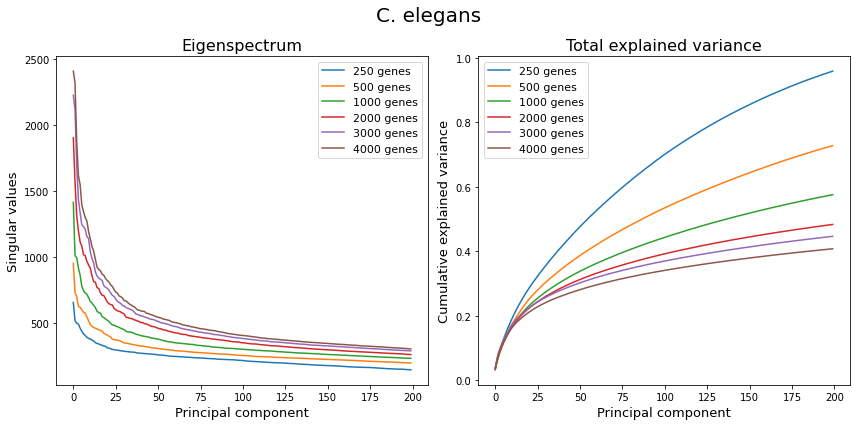

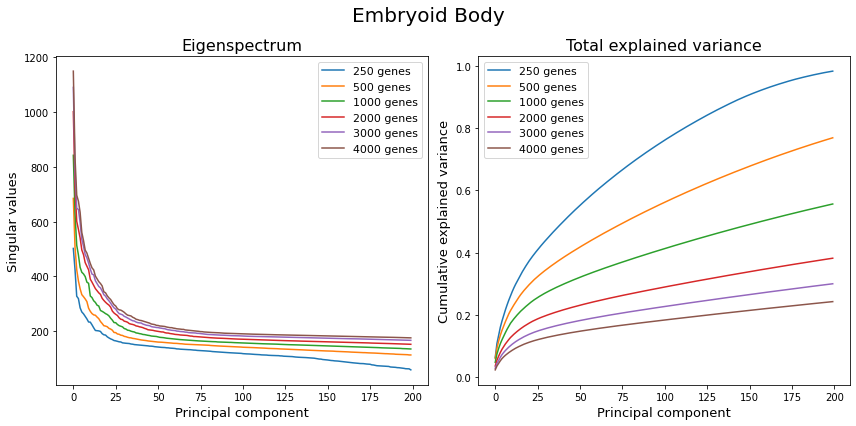

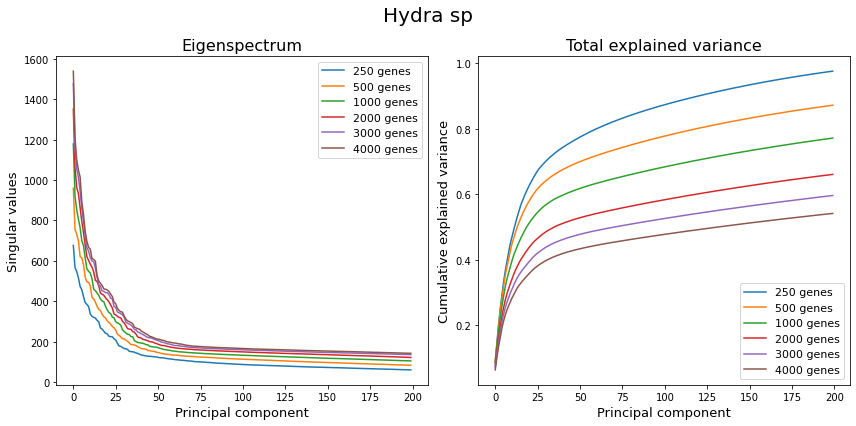

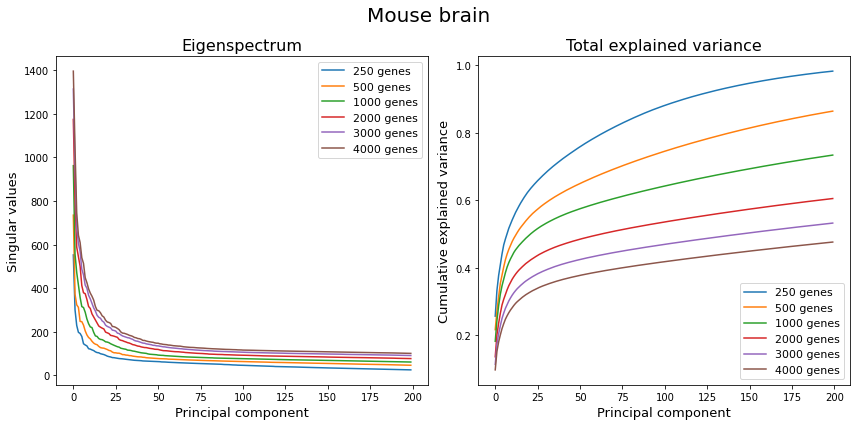

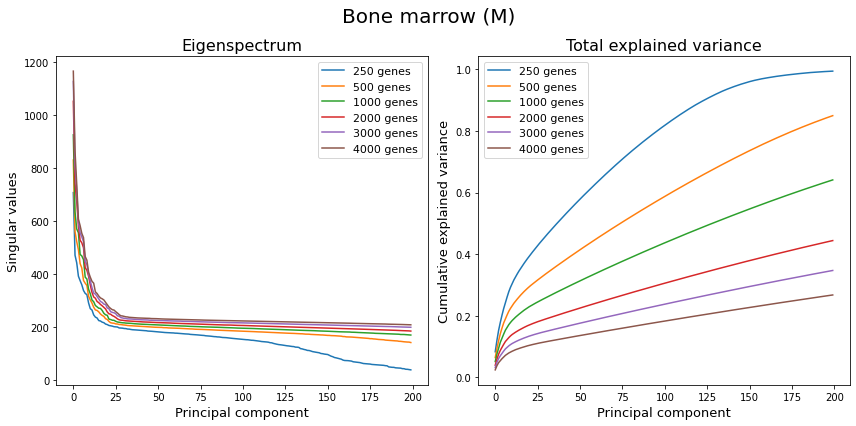

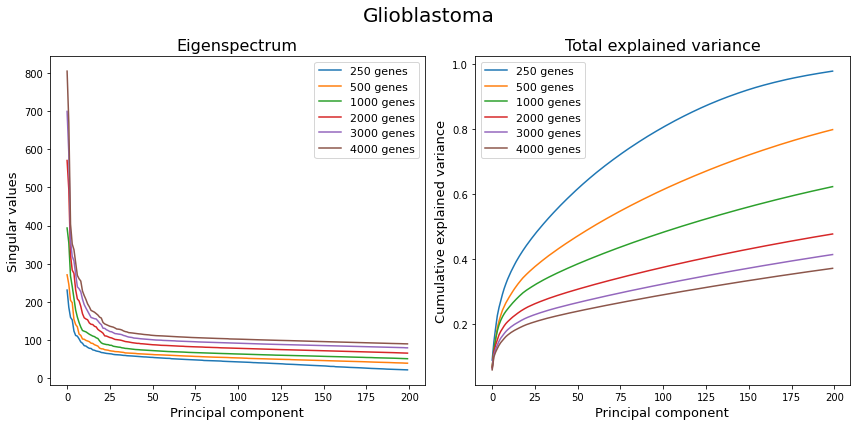

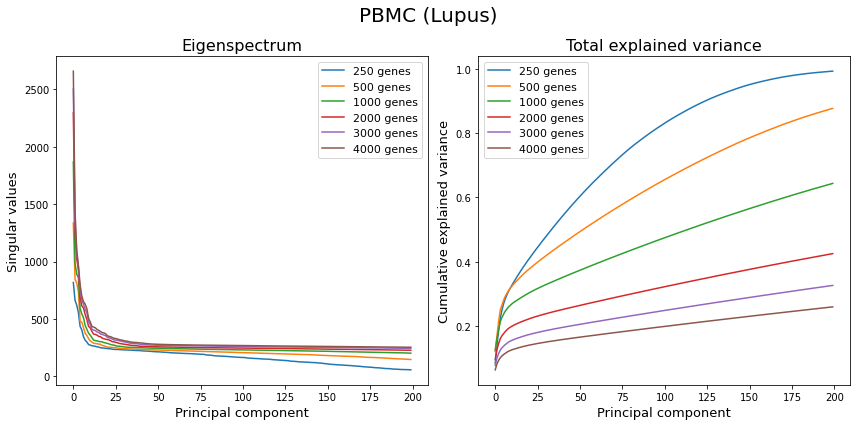

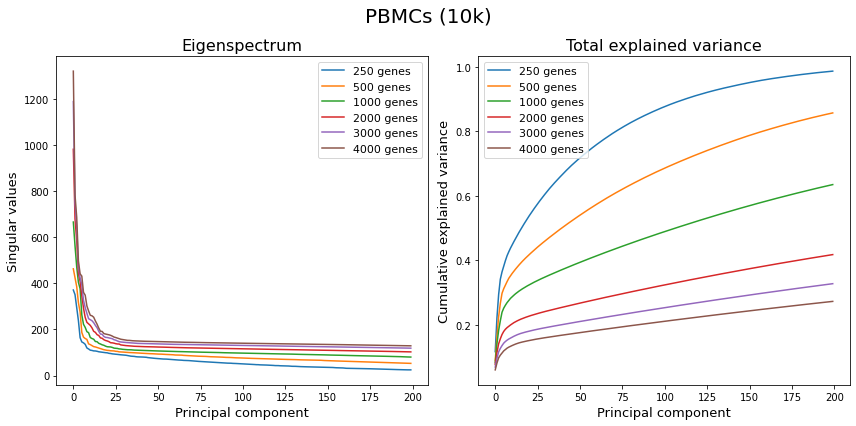

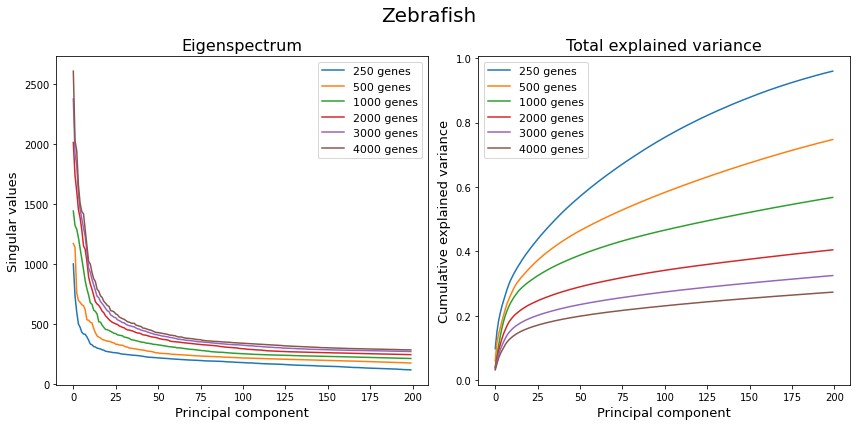

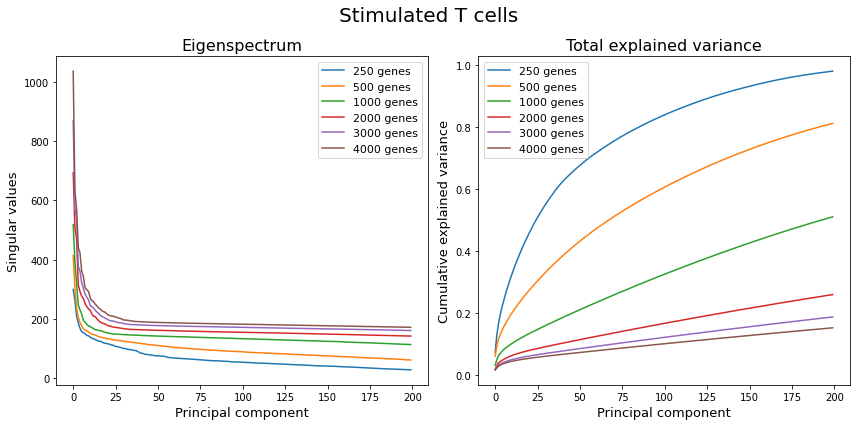

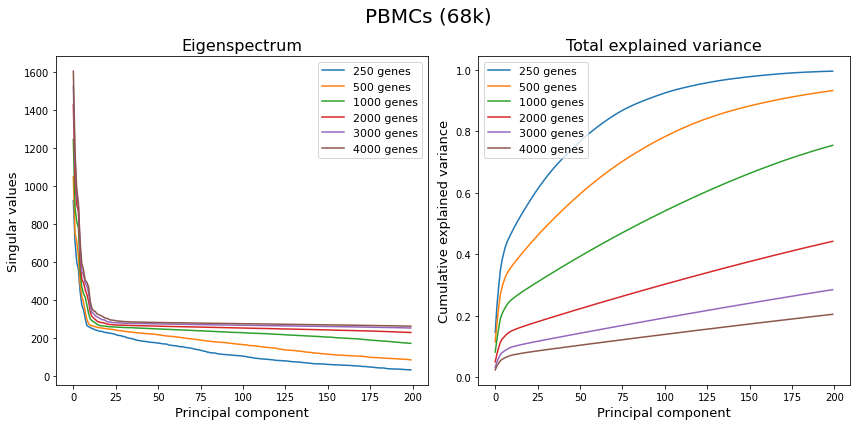

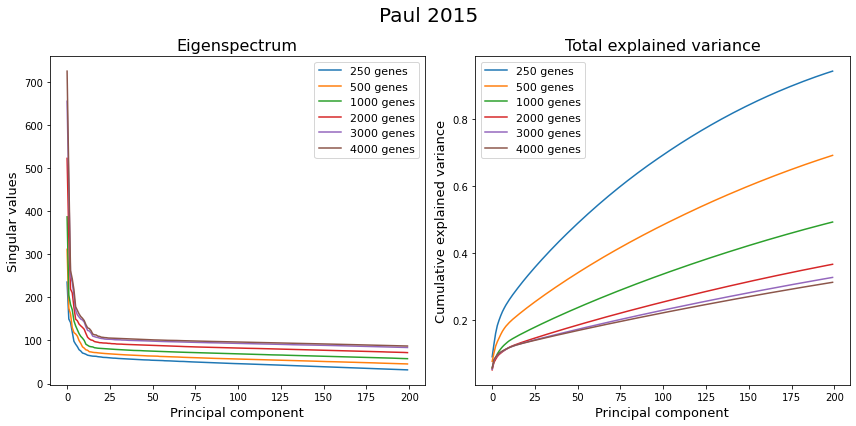

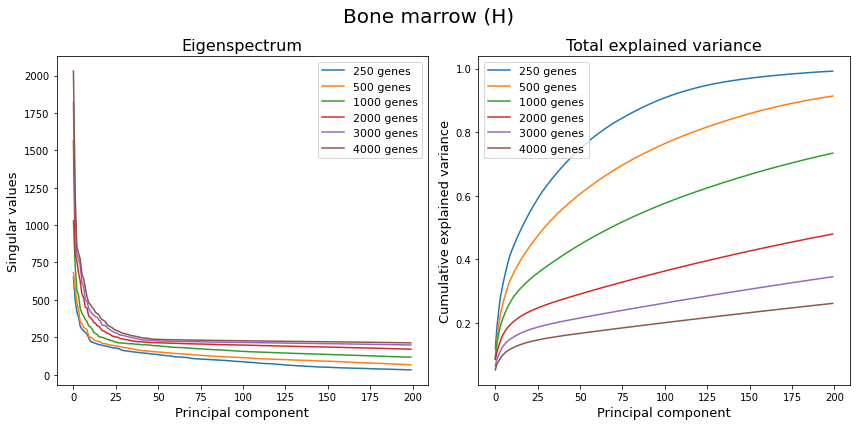

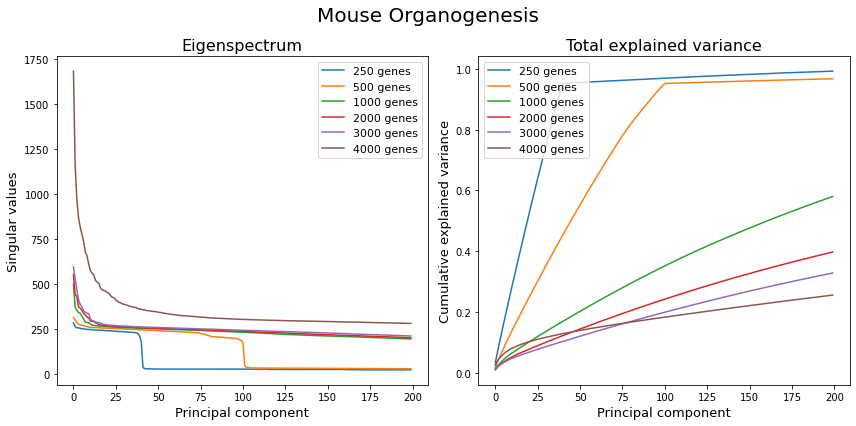

In [27]:
# Get the results for all datasets and plot their relation to gene number
#colors = ['blue', 'red', 'green', 'purple', 'brown', 'cyan']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, dataset in enumerate(explained_cov_ratio):
    plt.figure(figsize=(12,6))
    plt.subplots_adjust(left=0.2, right=0.98, bottom=0.001,
                        top=0.9, wspace=0.15, hspace=0.01)
    plt.suptitle(dataset, fontsize=20)
    for j, gene_number in enumerate(gene_number_range):
        plt.subplot(1, 2, 1)
        plt.plot(singular_values[dataset][gene_number], label='{} genes'.format(gene_number), color=colors[j])
        plt.title('Eigenspectrum', fontsize=16)
        plt.xlabel('Principal component', fontsize=13)
        plt.ylabel('Singular values', fontsize=13)
        plt.legend(fontsize=11)
        plt.subplot(1, 2, 2)
        plt.plot(explained_cov_ratio[dataset][gene_number].cumsum(), label='{} genes'.format(gene_number), color=colors[j])
        plt.title('Total explained variance', fontsize=16)
        plt.xlabel('Principal component', fontsize=13)
        plt.ylabel('Cumulative explained variance', fontsize=13)
        plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

In [37]:
exp_var_vs_n_genes = np.zeros((len(explained_cov_ratio), len(gene_number_range)))
exp_var_vs_n_genes.shape

(14, 6)

In [51]:
all_vars = []
for i, dataset in enumerate(explained_cov_ratio):
    #plt.figure(figsize=(5,5))
    exp_var_per_gene_number = []
    for j, gene_number in enumerate(gene_number_range):
        exp_var_per_gene_number.append(explained_cov_ratio[dataset][gene_number].cumsum().max())
    all_vars.append(exp_var_per_gene_number)

data_array = np.zeros(((len(explained_cov_ratio * len(gene_number_range))), 2))
for i in len(all_vars):
    list_to_append = all_vars[i]
    

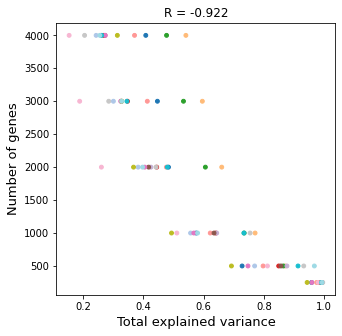

In [85]:
import itertools

x_axis = list(itertools.chain.from_iterable(all_vars))

y_axis = []
color_label = []

for i, dataset in enumerate(explained_cov_ratio):
    for gene_number in gene_number_range:
        y_axis.append(gene_number)
        color_label.append(i)

data_array = np.zeros(((len(explained_cov_ratio) * len(gene_number_range)), 2))
data_array[:, 0] = x_axis
data_array[:, 1] = y_axis

from scipy.stats import spearmanr
r_correlation = spearmanr(data_array[:, 0], data_array[:, 1])

plt.figure(figsize=(5,5))
plt.scatter(data_array[:, 0], data_array[:, 1], s=15, c=color_label, cmap='tab20')
plt.title('R = {}'.format(round(r_correlation[0],3), fontsize=16))
plt.xlabel('Total explained variance', fontsize=13)
plt.ylabel('Number of genes', fontsize=13)
plt.show()

In [ ]:
results_dict = evaluate_anndata_file_list(adata_files, n_pcs=100,
 metric='euclidean', n_neighbors=10, save_intermediate=True, save_dir=save_dir, verbose=True,
  not_normalize_idx=[13], return_dict=True)

In [ ]:
print_dict_results(results_dict)

In [ ]:
plot_sing_vals_exp_var(results_dict, fontsize=10)

In [ ]:
# Mean total explained variance
total_var_list = []
for i, dataset in enumerate(results_dict):
    total_var_list.append(results_dict[dataset]['explained_variance'].max())

print('Mean total explained variance: {}'.format(np.mean(total_var_list)))

In [ ]:
np.std(total_var_list)

In [ ]:
for i, dataset_name in enumerate(results_dict):
    print('\n \n  --- ' + str(dataset_name) + ' --- ' +
 '\n Spearman R correlation between the k-nearest-neighbors graphs learned from the data and the Principal Components: %f'%results_dict['graph_correlation'] +
 '\n Spearman R correlation between the geodesic distances in UMAP embeddings learned from these graphs %f'%results_dict['embedding_correlation'] +
 '\n Total explained variance with the first 100 PCs: %f'%results_dict['explained_variance'].max() +
 '\n Adjusted rand index (ARI) between clustering on top 100 PCs and on full data: %f'%results_dict['adjusted_rand_score'])